In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [335]:
train = pd.read_csv('data/train.csv')

In [336]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [337]:
round(train.isna().sum() / len(train),4) * 100

PassengerId     0.00
HomePlanet      2.31
CryoSleep       2.50
Cabin           2.29
Destination     2.09
Age             2.06
VIP             2.34
RoomService     2.08
FoodCourt       2.11
ShoppingMall    2.39
Spa             2.11
VRDeck          2.16
Name            2.30
Transported     0.00
dtype: float64

In [338]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [339]:
# sns.pairplot(train, hue='Transported')

In [340]:
[(i, train[i].nunique()) for i in train.columns]

[('PassengerId', 8693),
 ('HomePlanet', 3),
 ('CryoSleep', 2),
 ('Cabin', 6560),
 ('Destination', 3),
 ('Age', 80),
 ('VIP', 2),
 ('RoomService', 1273),
 ('FoodCourt', 1507),
 ('ShoppingMall', 1115),
 ('Spa', 1327),
 ('VRDeck', 1306),
 ('Name', 8473),
 ('Transported', 2)]

In [341]:
train.ShoppingMall.value_counts()

ShoppingMall
0.0       5587
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: count, Length: 1115, dtype: int64

<Axes: ylabel='Frequency'>

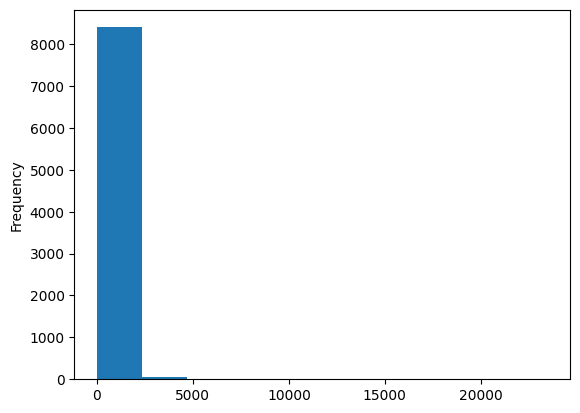

In [342]:
train.ShoppingMall.plot(kind='hist')

In [343]:
X_train = train.drop('Transported', axis=1)
y_train = train.Transported

In [344]:
X_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


In [345]:
class modifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()

        id_split = X_new.PassengerId.str.split('_').str
        cabin_split = X_new.Cabin.str.split('/').str

        X_new['Id_0'] = id_split[0]
        X_new['Id_1'] = id_split[1]
        X_new['CabinFirst'] = cabin_split[0]
        X_new['CabinLast'] = cabin_split[2]

        X_new['Alone'] = X_new.groupby('Id_0').transform(len).CabinLast.apply(lambda x: True if x == 1 else False)

        X_new.drop(['PassengerId', 'Name', 'Cabin', 'Id_0'], axis=1, inplace=True)
        
        # for i in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        #     X_new[i] = X_new[i].apply(lambda x: True if x == 0 else False) 
        
        return X_new

In [346]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [347]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

In [348]:
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'CabinFirst', 'CabinLast', 'Destination',
       'VIP', 'Id_1', 'Alone']

In [349]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [350]:
pipeline = Pipeline([
    ('modifyColumns', modifyColumns()),
    ('preprocessor', preprocessor),
    ('clf', SVC())
])

In [351]:
modifyColumns().transform(X_train)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id_1,CabinFirst,CabinLast,Alone
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,01,B,P,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,01,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,01,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,02,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,01,F,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,01,A,P,True
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,01,G,S,True
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,01,G,S,True
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,01,E,S,False


In [352]:
param_grid = {
    'clf': [
        CatBoostClassifier(),
        SVC()
    ]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Learning rate set to 0.025939
0:	learn: 0.6796751	total: 146ms	remaining: 2m 25s
1:	learn: 0.6683245	total: 151ms	remaining: 1m 15s
2:	learn: 0.6571639	total: 156ms	remaining: 51.9s
3:	learn: 0.6459747	total: 162ms	remaining: 40.4s
4:	learn: 0.6352602	total: 167ms	remaining: 33.3s
5:	learn: 0.6253645	total: 173ms	remaining: 28.7s
6:	learn: 0.6156421	total: 178ms	remaining: 25.3s
7:	learn: 0.6081154	total: 183ms	remaining: 22.7s
8:	learn: 0.5994159	total: 188ms	remaining: 20.7s
9:	learn: 0.5914368	total: 193ms	remaining: 19.1s
10:	learn: 0.5846822	total: 198ms	remaining: 17.8s
11:	learn: 0.5773543	total: 205ms	remaining: 16.9s
12:	learn: 0.5715408	total: 211ms	remaining: 16s
13:	learn: 0.5663254	total: 216ms	remaining: 15.2s
14:	learn: 0.5604025	total: 221ms	remaining: 14.5s
15:	learn: 0.5550260	total: 227ms	remaining: 14s
16:	learn: 0.5503175	total: 232ms	remaining: 13.4s
17:	learn: 0.5462498	total: 238ms	remaining: 13s
18:	learn: 0.5396358	total: 244ms	remaining: 12.6s
19:	learn: 0.53

In [353]:
test = pd.read_csv('data/test.csv')

In [354]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [355]:
best_model = grid_search.best_estimator_

y_test = best_model.predict(test)

print("Predictions: ", y_test)

Predictions:  [ True False  True ...  True  True  True]


In [356]:
result = pd.DataFrame(y_test, columns=['Transported'])

In [357]:
test.join(result)[['PassengerId', 'Transported']].to_csv('submission.csv', index=False)

In [358]:
modifyColumns().transform(X_train)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id_1,CabinFirst,CabinLast,Alone
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,01,B,P,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,01,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,01,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,02,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,01,F,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,01,A,P,True
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,01,G,S,True
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,01,G,S,True
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,01,E,S,False


In [359]:
modifyColumns().transform(test)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id_1,CabinFirst,CabinLast,Alone
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,01,G,S,True
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,01,F,S,True
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,01,C,S,True
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,01,C,S,True
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,01,F,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,02,G,S,False
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,01,NaN,NaN,True
4274,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,01,D,P,True
4275,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,01,D,P,True
